# Getting Started With WOfS Confidence

| Author(s):  | Arapaut Sivaprasad|
|----------|----------------|
| Created: | Jun 07, 2018 |
| Last Modified: | Jun 07, 2018 |
| Acknowledgemments: | Belle, Imam, Andrew Hicks |

## Objectives
The main objective is to Add the Ancillary datasets into the 'wofs_confidence' database. This document explains how to do it with the "Multi-resolution Valley-Bottom-Flatness (MrVBF)" datasets.

### Background Information [[1](http://www.ga.gov.au/scientific-topics/hazards/flood/wofs)]

"Water Observations from Space (WOfS) is a web service displaying historical surface water observations derived from satellite imagery for all of Australia from 1987 to present day. WOfS aims is to allow better understanding of where water is usually present; where it is seldom observed; and where inundation of the surface has been occasionally observed by satellite. WOfS displays the detected surface water from the Australia-wide Landsat 5 and Landsat 7 satellite imagery archive."

In order to say with confidence that a pixel classified as water requires additional information that affirms the classification. For example, if the location is the bottom of a valley it is very likely that the location denoted by that pixel has water. But, if it is the slope of a hill, chances are that the observation is false.

The MrVBF ancillary database is a measure of the terrain. This information is gathered from all "tiles" across Australia into a series of NetCDF (*.nc*) files. Objective of this exercise is to add these to the database so that the info can be used later to analyse the WOfS data.

#### What is confidence? [[2](http://www.ga.gov.au/scientific-topics/hazards/flood/wofs/water-observations-from-space-help)]
The confidence probability is a measure of how confident we are that a location flagged as water is truly water. The confidence information was created by comparing the WOfS with other data, to see how well it matched known water areas from other sources. 

These sources are:

- Multi-resolution Valley-Bottom-Flatness (**MrVBF**). This uses the terrain across Australia to work out whether an area is likely to be on or near a valley bottom or flat area where water could accumulate.

- MODIS Open Water Likelihood (MODIS OWL). This is a product similar to WOfS, derived from the low resolution MODIS satellites, showing the likelihood that an area has contained water between 2000 and 2012.

- Australian Hydrological Geospatial Fabric (Geofabric). This is a spatial database of Australian water features, including rivers, lakes, flood plains and other water features.

- Terrain slope. This is a second factor created from the terrain. The steeper the terrain, the less likely that water will accumulate in the location.

- Built-up urban areas. The way light is reflected from large buildings and their shadows causes considerable water detection errors in cities. The more built-up an area, the less likely that water will be correctly detected there.
O
- Observation frequency. Areas where the observation frequency is low typically have poor conditions for water detection. The higher the observation frequency, the more likely that a good water/non-water classification can occur.


## Pre-requisites

### Setup the environments

- To access the database, add the following into your 'datacube.conf' file

> e.g. **/g/data/u46/users/sa9525/datacube.conf**

    [confidence]
    db_hostname: agdcstaging-db.nci.org.au
    db_port: 6432
    db_database: wofs_confidence
    db_connection_timeout: 60000

- Invoke the database by the 'psql' command as below.

> **psql -h agdcstaging-db.nci.org.au -p 6432 -d wofs_confidence**

- Useful commands within Psql:
    - \l: List of databases
    - \d: List of tables
    - \d table: Display the table structure
    - \h: List of all commands
    - \h command: Specific help on the command
    - \q: Exit
    
- SQL queries are almost identical to those in MySQL

- To use the above database alongwith datacube, use the following command.
    
>    **datacube -E confidence**



- The list of tables we deal with are:

                            List of relations

| Schema |                  Name                   |   Type   |   Owner |
|-|-|-|-|
| agdc   | dataset                                 | table    | agdc_admin |
| agdc   | dataset_location                        | table    | agdc_admin |
| agdc   | dataset_source                          | table    | agdc_admin |
| agdc   | dataset_type                            | table    | agdc_admin |


### Enter the product details
The product details define the type of the products we are going to enter. For example, 'mrvbf' is a product type. This info is first entered into the database via a YAML file shown below.

e.g. **avs_mrvfb.yaml:**

    name: mrvbf
    description: MrVBF ancillary data for wofs confidence
    metadata_type: eo
    
    metadata:
      product_type: mrvbf
      format:
        name: GeoTiff
    
    measurements:
      - name: band1
        dtype: uint8
        units: '1'
        nodata: 255
    
    storage:
      crs: EPSG:4326
      resolution:
        latitude: -0.00025
        longitude: 0.00025
    

#### Add the product definitions to the database as a shell command (not from PSQL):

> **datacube product add avs_mrvfb.yaml**

If you make any change in the above YAML file, then update via the following. NOTE: There is no way to delete a product type once entered (strange!) except manually from the database table.

> **datacube product update --allow-unsafe avs_mrvfb.yaml**

These need to be done only once for a product type.

You must have database/table insert privilege to give the above commands. If not, ask the admin to do a `grant all privileges on database wofs_confidence to your_userID`



### Enter the dataset details
We must specify that the datasets belong to a product type. For this, we insert the details via another YAML file:

e.g. **avs_mrvbf_nc.yaml:**

    name: mrvbf_nc
    description: MrVBF ancillary data for wofs confidence
    metadata_type: eo
    
    metadata:
      product_type: mrvbf
      format:
        name: NetCDF
    
    measurements:
      - name: band1
        dtype: uint8
        units: '1'
        nodata: 255
    
    storage:
        crs: EPSG:3577
        dimension_order:
        - time
        - y
        - x
        driver: NetCDF CF
        resolution:
            x: 25
            y: -25
        tile_size:
            x: 100000.0
            y: 100000.0
    

#### Add the dataset definitions to the database as a shell command (not from PSQL):

> **datacube product add avs_mrvfb_nc.yaml**

If you make any change in the above YAML file, then update via the following. NOTE: There is no way to delete a product type once entered (strange!)

> **datacube product update --allow-unsafe avs_mrvfb_nc.yaml**

These need to be done only once for a product type.

## Index the datasets

Indexing the datasets is a bit different to that in MySQL. Here, we are NOT indexing a column as in 'create index ...' command. In fact, the data itself is not loaded into the database tables at all. All we are doing is adding the some metadata into the tables and keep the data as files on the disk. Therefore, the locations and permanency of these files are critical. The term ,'index', probably refers to this information.

### Enter the datasets

Once the product and dataset definitions have been entered, we can enter the datasets.

The datasets are kept in NetCDF or GeoTiff formats. In the above YAML we have indicated that they are in NetCDF format. Therefore, we can enter and index a dataset by the following command.

> **datacube dataset add mrvbf_9_-49.nc**

> where, **mrvbf_9_-49.nc** is the filename of the data for one tile. 

We must enter all tiles (~1600) by repeating the above command. Obviously, we will use a shell script to do so.

### Enter the datasets in bulk
It will be extremely time consuming to add the datasets one by one as given above. Instead, we can do it in bulk by the following steps.

**STEPS:**

- Create a list of all datasets in the appropriate directory.

    - `find /g/data/u46/wofs/confidence_albers/MrVBF/tiles/*.nc | awk '{printf "echo %s; datacube -E confidence dataset add %s\n",$1, $1}' > MrVBF.sh`

- Execute the output file from above with the command below.
    - **source** `MfVBF.sh &`
    
**Alternatively,**

- Execute the following program.

    - **/g/data/u46/users/sa9525/avs/WOfS/insert_all.py** `/g/data/u46/wofs/confidence_albers/MrVBF/tiles/ &`
    
    
**Tip:** If you run the program in the background as the above two commands show, it is possible to kill the job with **kill %1**. Otherwise, it may not be possible to interrupt.


### Delete the datasets
If, for any reason, you want to delete all the entered datasets and start over, do the following. NOTE: It is a brute force method. It will delete everything in the tables and should be used only as a last resort. To reload a single dataset you can do a *datacube -E confidence dataset update filename*

- Connect to the database
    
    - **psql -h agdcstaging-db.nci.org.au -p 6432 -d wofs_confidence**

- Run these commands, **in the same order** as given below.
    
    - delete from dataset_source;
    
    - delete from dataset_location;
    
    - delete from dataset;


## Verify the integrity of all datasets 
After the dataset(s) are indexed, it is probably a good idea to check the integrity of data. Since we are not actually adding or modifying the data in any way, but instead just adding the metadata and file locations into the database, chances of something going wrong are less. However, many datasets may not have any data. This can be visually seen by the file sizes, or can be verified by looking at the actual data in there.

It is not practical to test all datasets by plotting their data (as given below). A script, however, can test them and say which ones are empty and/or an error in any of them.

To do it, run the following script from shell after appropriately defining the list of dataset files.

> **/g/data/u46/users/sa9525/avs/WOfS/check_integrity.py**

**STEPS:**
- Create a list of all tiles in the appropriate directory.
    
    - find /g/data/u46/wofs/confidence_albers/MrVBF/tiles/*.nc | awk '{printf "%s\n",\$1}' > MrVBF.txt
    
- **/g/data/u46/users/sa9525/avs/WOfS/check_integrity.py** MfVBF.txt [integrity.txt]

- Results will be in ./integrity.txt or ./MfVBF.txt_integrity.txt, if filename is omitted
    
    1. mrvbf_0_-11.nc : Dataset is \*\*\*empty\*\*\*. File size: 0.13M
    
    2. mrvbf_0_-12.nc : Dataset has valid data. File size: 1.49M
    
    3. etc.
    

## Verify the integrity of a single dataset manually

Before proceeding with adding all datasets, as described in 1.3.2 above, it is advisable to add a small number and verify their integrity. Remember that, as in the case of product definitions, we cannot delete a dataset once added. If you mess up, it will be easier to delete all in the tables and start all over.  

One way to check the integrity at present is to plot a single dataset, selected at random, by following the instructions below. It will show a plot if there is any data in the tile. If not, the plot will be empty.


### Find the geo-coordinates of the dataset
If we know the latitude and longitude of the tile that represents the dataset, its data can be loaded and plotted. To find these coordinates, do the following.

- Change dir to the location of the datafiles.

    - e.g. **cd /g/data/u46/wofs/confidence_albers/MrVBF/tiles**

- Run the following command.

> **gdalinfo NETCDF:/g/data1a/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_9_-49.nc:band1 | grep NC_GLOBAL **

Output will look like this.

      NC_GLOBAL#Conventions=CF-1.6, ACDD-1.3
      NC_GLOBAL#date_created=2018-01-12T09:05:13.376699
      NC_GLOBAL#geospatial_bounds=POLYGON ((142.768498169369 -43.5806858162346,142.870058833737 -44.5126214850899,144.071023384885 -44.4285210281062,143.958367272651 -43.4978773388109,142.768498169369 -43.5806858162346))
      NC_GLOBAL#geospatial_bounds_crs=EPSG:4326
      NC_GLOBAL#geospatial_lat_max=-43.49787733881086
      NC_GLOBAL#geospatial_lat_min=-44.51262148508991
      NC_GLOBAL#geospatial_lat_units=degrees_north
      NC_GLOBAL#geospatial_lon_max=144.0710233848853
      NC_GLOBAL#geospatial_lon_min=142.7684981693691
      NC_GLOBAL#geospatial_lon_units=degrees_east
      NC_GLOBAL#history=NetCDF-CF file created by datacube version '1.5.1+147.g98ca9c5.dirty' at 20180111.
      NC_GLOBAL#title=MrVBF ancillary data for WOfS confidence
      
- Get the **lat_min, lat_max, lon_min** and **lon_max** from above.

- Compose a 'query' like below.

      query = {
       'lat': (-44.51262148508991, -43.49787733881086),
       'lon': (142.7684981693691, 144.0710233848853),
        'crs': ('EPSG:4326')
        }
        
- Run this notebook and see that it returns some data and plots a picture.


### Quick way to create the query dict

To make the co-ordinates like above in a quicker way, use the following Perl script.

- cd /g/data/u46/wofs/confidence_albers/MrVBF/tiles

> **/g/data/u46/users/sa9525/avs/WOfS/get_lat_lon.pl mrvbf_9_-42.nc**

- Copy and paste the query dict into its box below.


### Run the data extraction and plotting

In [50]:
import sys
import os.path
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
from DEAPlotting import three_band_image_subplots, three_band_image

In [51]:
import datacube
from datacube import Datacube

In [52]:
dc = Datacube(env="confidence")

In [53]:
query = {
           'lat': (-32.11323592973712, -31.21609389215025),
           'lon': (132, 133.0688678253822),
           'crs': ('EPSG:4326')
         }


### Display the data

In [54]:
ds = dc.load(product='mrvbf_nc', group_by='solar_day', **query)
ds.band1.values[0][0]

array([  8,   8,   8, ..., 255, 255, 255], dtype=uint8)

In [55]:
ds.band1.values.shape

(1, 4034, 4034)

In [56]:
import numpy

In [57]:
numpy.all(ds.band1.values == 255)

False

In [58]:
m = 0
for n in ds.band1.values[0][0]:
    if (n != 255): 
        m =1
print(m)

1


The next statement will show a partial list of the datasets in the database.

In [59]:
dc.find_datasets(product='mrvbf_nc', group_by='solar_day', **query)

[Dataset <id=1668072a-8383-4cb0-8817-9f912e688df6 type=mrvbf_nc location=/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_0_-34.nc>,
 Dataset <id=89a59bb9-3a07-426e-bd70-778ff4baa951 type=mrvbf_nc location=/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_0_-35.nc>,
 Dataset <id=d710895d-e4e9-4a33-b2a8-0d64e894b8ee type=mrvbf_nc location=/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_0_-36.nc>,
 Dataset <id=839e54b1-b141-4fdd-80f1-30fca7e97af4 type=mrvbf_nc location=/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_1_-35.nc>]

### Plot the data

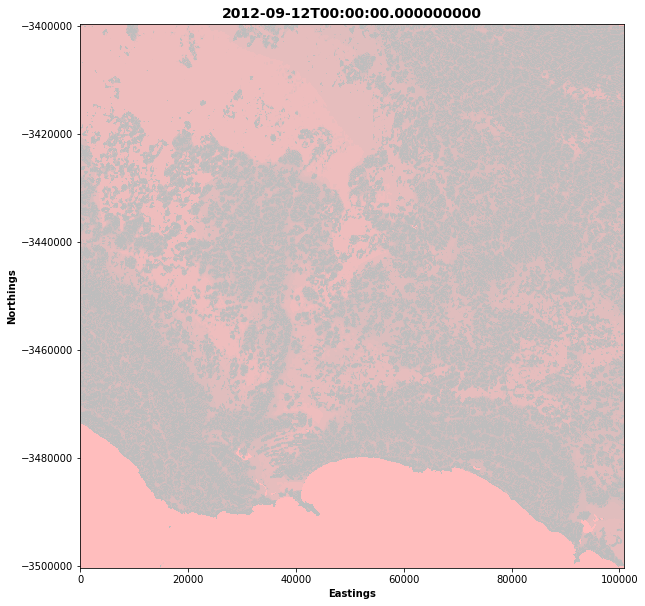

In [60]:
three_band_image(ds, bands = ['band1'], time = 0, contrast_enhance=True);